# Enhanced MNIST Classifier with Improved Preprocessing
Optimized for black digits on white background images

## 1. Install & Import Dependencies

In [1]:
# !pip install torch torchvision opencv-python-headless matplotlib

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Set random seeds
torch.manual_seed(42)
np.random.seed(42)

## 2. Enhanced Data Loading with Augmentation

In [2]:
train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, translate=(0.1, 0.1)),
    transforms.RandomResizedCrop(28, scale=(0.8, 1.2)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST('./data', train=True, download=True, transform=train_transform)
test_dataset = datasets.MNIST('./data', train=False, transform=test_transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=256, shuffle=False)

## 3. Improved CNN Architecture

In [4]:
class EnhancedNet(nn.Module):
    def __init__(self):
        super(EnhancedNet, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.4),
            
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.4)
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(64*7*7, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 10)
        )
        
    def forward(self, x):
        x = self.conv_block(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return F.log_softmax(x, dim=1)

model = EnhancedNet()

## 4. Training with Advanced Regularization

In [5]:
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)
criterion = nn.CrossEntropyLoss()

def train(epoch):
    model.train()
    total_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')
    return total_loss / len(train_loader)

def test():
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} '
          f'({accuracy:.2f}%)\n')
    return test_loss

# Train for 50 epochs
best_loss = float('inf')
for epoch in range(1, 51):
    train_loss = train(epoch)
    test_loss = test()
    scheduler.step(test_loss)
    
    # Save best model
    if test_loss < best_loss:
        best_loss = test_loss
        torch.save(model.state_dict(), 'best_model.pt')
        print('Model saved!')


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.380313
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.326161
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.140642
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.172850
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.178238

Test set: Average loss: 0.0002, Accuracy: 9875/10000 (98.75%)

Model saved!
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.169877
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.172280
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.100262
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.091432
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.055288

Test set: Average loss: 0.0001, Accuracy: 9908/10000 (99.08%)

Model saved!
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.131665
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.059812
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.188525
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.071529
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.094175

Test set: Average loss: 0.0001, Accuracy: 9931/10000 (99.31%)

Model saved!
Train Epoch: 4 [0/60000 (0%)]	Loss

## 5. Enhanced Image Preprocessing

In [6]:
def enhanced_preprocess(image_path):
    # Read image with OpenCV
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Threshold and invert
    _, thresh = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY_INV)
    
    # Remove noise
    kernel = np.ones((2,2), np.uint8)
    processed = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
    
    # Find and center main contour
    contours, _ = cv2.findContours(processed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        cnt = max(contours, key=cv2.contourArea)
        x,y,w,h = cv2.boundingRect(cnt)
        roi = processed[y:y+h, x:x+w]
        
        # Maintain aspect ratio
        if h > w:
            new_h = 20
            new_w = int(w * (20 / h))
        else:
            new_w = 20
            new_h = int(h * (20 / w))
        
        resized = cv2.resize(roi, (new_w, new_h))
        
        # Center in 28x28 canvas
        canvas = np.zeros((28, 28), dtype=np.uint8)
        dx = (28 - new_w) // 2
        dy = (28 - new_h) // 2
        canvas[dy:dy+new_h, dx:dx+new_w] = resized
    else:
        canvas = processed  # Fallback
    
    # Convert to tensor
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    
    # Visualize preprocessing
    plt.figure(figsize=(6,3))
    plt.subplot(1,2,1)
    plt.title('Original')
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
    plt.subplot(1,2,2)
    plt.title('Processed')
    plt.imshow(canvas, cmap='gray')
    plt.axis('off')
    plt.show()
    
    return transform(Image.fromarray(canvas)).unsqueeze(0)

## 6. Prediction with Best Model

In [9]:
# Load best model
model.load_state_dict(torch.load('best_model.pt'))
model.eval()

def predict_digit(image_path):
    tensor = enhanced_preprocess(image_path)
    with torch.no_grad():
        output = model(tensor)
    return output.argmax().item()



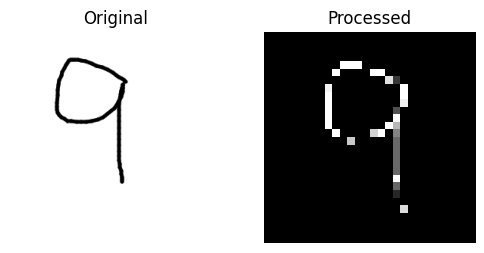

Predicted digit: 9


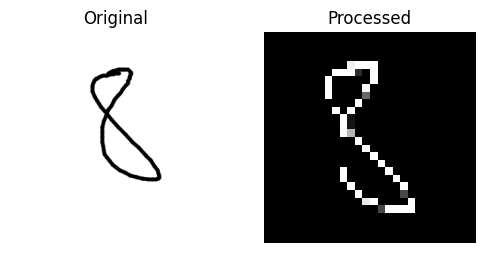

Predicted digit: 8


In [ ]:
# Example usage:
prediction = predict_digit('drawing1.png')
print(f"Predicted digit: {prediction}")
prediction = predict_digit('drawing2.png')
print(f"Predicted digit: {prediction}")